In [ ]:
pwd

## Import packages

In [1]:
%matplotlib notebook

import os
import tifffile as tiff
import numpy as np
import matplotlib.pyplot as plt

#Peak detection
from scipy import ndimage
from scipy.ndimage.filters import maximum_filter
from scipy.ndimage.morphology import generate_binary_structure, binary_erosion
from scipy.signal import find_peaks
from scipy import optimize
import matplotlib.patches as patches
from matplotlib.colors import LogNorm
from scipy.interpolate import griddata
from tqdm import tqdm
import math
import seaborn as sns

import pandas as pd
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
#import lmfit
#from lmfit.lineshapes import gaussian2d, lorentzian

from scipy.optimize import curve_fit

## Functions for gaussian fit

In [2]:
def gaussian(height, center_x, center_y, width_x, width_y):
    """Returns a gaussian function with the given parameters"""
    width_x = float(width_x)
    width_y = float(width_y)
    return lambda x,y: height*np.exp(
                -(((center_x-x)/width_x)**2+((center_y-y)/width_y)**2)/2)

def moments(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution by calculating its
    moments """
    total = data.sum()
    X, Y = np.indices(data.shape)
    x = (X*data).sum()/total
    y = (Y*data).sum()/total
    col = data[:, int(y)]
    width_x = np.sqrt(np.abs((np.arange(col.size)-x)**2*col).sum()/col.sum())
    row = data[int(x), :]
    width_y = np.sqrt(np.abs((np.arange(row.size)-y)**2*row).sum()/row.sum())
    height = data.max()
    return height, x, y, width_x, width_y


def fitgaussian(data):
    """Returns (height, x, y, width_x, width_y)
    the gaussian parameters of a 2D distribution found by a fit"""
    params = moments(data)
    errorfunction = lambda p: np.ravel(gaussian(*p)(*np.indices(data.shape)) -
                                 data)
    p, success = optimize.leastsq(errorfunction, params)
    return p

This script should:

    1. Load a tiff image: load_image(filename)
    2. Detect beam positions; extract_beam_pos(arr)
    3. For a sequence of in-and-out of focus images, do 1 and 2; For each return a dictionary with the beams information
        {"pixel 3x3": [x_pos, y_pos, beam_radius]]}: 
    3. From the n pictures and respective n dictionaries, extract for each pixel the x-z and x-y profiles and extract the respective angles;

## Functions to load images

In [3]:
filenames = [item for item in os.listdir() if ".tiff" in item]
z_pos_arr = [float(item.split("_")[1].replace("mm", "")) for item in filenames]
filenames = [x for _,x in sorted(zip(z_pos_arr, filenames))]

In [4]:
# Load tiff image
def load_image(filename):
    img = tiff.imread(filename)
    img_arr = np.array(img)
    return img_arr

def crop_rotate_image(img_arr, crop, angle = 1):
    """
    crop = [idx_x_min, idx_x_max, idx_y_min, idx_y_max]
    """
    idx_x_min, idx_x_max, idx_y_min, idx_y_max = crop
    img_arr = ndimage.rotate(img_arr, 1, reshape=False)
    img_arr = img_arr[idx_x_min: idx_x_max, idx_y_min: idx_y_max]
    return img_arr

def plot_image(img_array):
    f, ax = plt.subplots()
    im = ax.imshow(img_array, origin = "lower", cmap = "gray")
    f.colorbar(im)
    return f, ax

    

### Load test

<IPython.core.display.Javascript object>


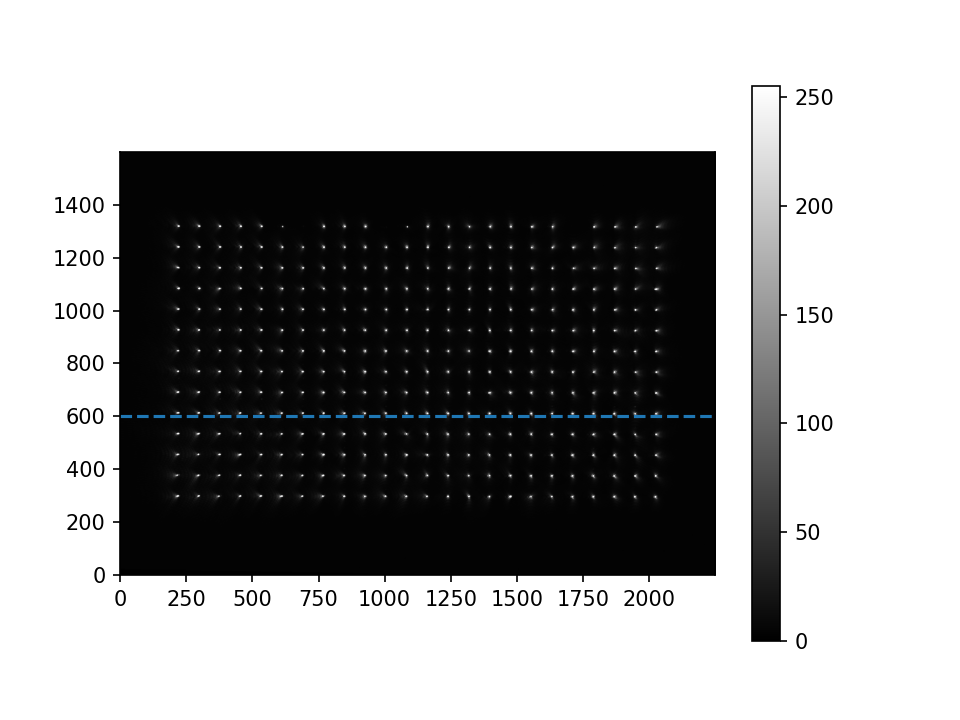

In [5]:
img_arr = load_image(filenames[4])
idx_x_min, idx_x_max, idx_y_min, idx_y_max = [0, 1600, 50, 2300]
img_arr = crop_rotate_image(img_arr, angle = 1, crop = [idx_x_min, idx_x_max, idx_y_min, idx_y_max])
f, ax = plot_image(img_arr)
ax.axhline(y=600, linestyle = "--")


## Functions to extract beam positions

At this stage the image should be rotated and cropped, ensuring that the lines and columns are aligned horizontally and vertically.

In [6]:
box_width = 44
magnification = 1  #microns per pixel

def extract_naive_beam_pos(img_arr):
    #naive extraction of beam positions - idx_y
    h_sum = img_arr.sum(axis = 0) #sum along columns
    h_sum = h_sum / np.max(h_sum)
    y_peaks, _ = find_peaks(h_sum, distance = 40, prominence = 0.01) #peaks along horizontal direction - idx_y
    y_spacing = np.mean(np.diff(y_peaks))

    v_sum = img_arr.sum(axis = 1) #sum along rows
    v_sum = v_sum / np.max(v_sum)
    x_peaks, _ = find_peaks(v_sum, distance = 40, prominence = 0.01) #peaks along vertical direction - idx_y
    x_spacing = np.mean(np.diff(x_peaks))

    beam_naive_pos_dict = {f"{idx_x}x{idx_y}": [peak_x, peak_y] for idx_x, peak_x in enumerate(x_peaks) 
                                                     for idx_y, peak_y in enumerate(y_peaks)}
    
    global magnification
    magnification = np.mean([220./x_spacing, 220./y_spacing])
    return beam_naive_pos_dict



def recentre_roi_beam(img_arr, beam_naive_pos_dict, plot = True, ax = ax):
    """
    For each individual beam, find ROI (region of interest) and updates beam_naive_pos_dict
    by matching the center of the ROI to the centroid of the sub_img_arr of each beam
    
    Args:
        img_arr (np array): image
        beam_pos_dict (dict): dictionary with naive beam positions;
    """
    
    #Center each rectangle around the centroid of the sub_array and perform a Guassian fit
    for key, box_pos_arr in beam_naive_pos_dict.items():
        peak_x, peak_y = box_pos_arr
        
        sub_img_arr = img_arr[int(peak_x - box_width/2): int(peak_x + box_width/2),
                             int(peak_y - box_width/2): int(peak_y + box_width/2)]

        #recentre sub array around center of mass
        COM = np.array(ndimage.center_of_mass(sub_img_arr))
        beam_naive_pos_dict[key] = np.array([peak_x - box_width/2 + COM[0], #box center positions
                                        peak_y - box_width/2 + COM[1]]) 
        if plot:
            rect = patches.Rectangle((beam_naive_pos_dict[key][1]-box_width/2,
                                      beam_naive_pos_dict[key][0]-box_width/2),
                                     box_width, box_width, linewidth=1, edgecolor='g', facecolor='none')
            ax.add_patch(rect)

    return beam_naive_pos_dict 


def extract_beam_pos(img_arr, beam_naive_pos_dict, plot = True, ax = ax):
    """
    Divides image into small regions of interest around individual beams. For each, calculate a
    2D gaussian fit, to localise the point of maximum brightness.
    
    Args:
        img_arr (arr) - image
        beam_naive_pos_dict (dict) - Contains the coordinates of the center of the individual ROIs
        plot (bool) - plot scatter points that identifiy the beam position
        
    Returns:
        dict: beam pos dict - each entry contains the x,y coordinates of the beam in the image and the
            sub_x, sub_y coordinates of the beam within the ROIs
        list: beam_sub_arr - contains the subarrays corresponding with the invidiual ROIs
    
    """
    beam_pos_dict = {}
    beam_sub_arr = []
    
    for key, box_pos_arr in tqdm(beam_naive_pos_dict.items()):
        peak_x, peak_y = box_pos_arr
        
        sub_img_arr = img_arr[int(peak_x - box_width/2): int(peak_x + box_width/2),
                             int(peak_y - box_width/2): int(peak_y + box_width/2)]
    
        #Fit a gaussian to the beam
        X_arr, Y_arr = np.meshgrid(np.linspace(0, sub_img_arr.shape[0]-1, sub_img_arr.shape[0]),
                                     np.linspace(0, sub_img_arr.shape[0]-1, sub_img_arr.shape[0]))

        params = fitgaussian(sub_img_arr, )
        (height, x_sub, y_sub, width_x, width_y) = params #x_sub is x pixel coordinate within sub_img_arr

        if (x_sub<0) or (x_sub>box_width) or (y_sub<0) or (y_sub>box_width):
            print (f"Fit did not converge for pixel {key}: x={x: .2f}, y={y: .2f}")
            continue

        x = x_sub + peak_x - box_width/2.
        y = y_sub + peak_y - box_width/2.

        beam_pos_dict[key] =  [np.array([x, y]), np.array([x_sub, y_sub])]
        beam_sub_arr.append(sub_img_arr)
        
        if plot:
            ax.scatter(x = y,
                        y = x,
                        color = "orange", s = 2)
    
    return beam_pos_dict, beam_sub_arr
    
    
def extract_beam_data(img_arr, z_pos, box_width = 44, plot = True):
    """
    Takes the image of nxm array of beams and extracts the beam data (e.g. z pos of chip,
    each beam position in pixel coordinates, each pixel position in pixel coordinates, but within
    its individual region of interest and the cropped array corresponding to the ROI.)
    The sequence of transformations are:
        1. The regions of interest of each beam are calculated with a naive approach.
        2. The ROIs are recentred in the centroid of the ROI sub array, for better accuracy
        3. The beam position in pixel coordinates is extracted by a 2D gaussian fit.
    
    Args:
        img_arr (numpy 2D array) : image loaded from .tiff file
        z_pos (float): position of chip along optical axis
        box_width (int): Width of the boxes around detected peaks
        plot (bool): Generate images of data
        
    Returns
        dict: dictionary with keys in the form "24x5" with val as a list with:
                z_pos - position of chip along optical axis
                [x, y] - pixel positions (x,y) within image
                [x_sub, y_sub] - pixel position (x_sub, y_sub) within box surrounding beamm (box_width)
                sub_img_arr - image of individual beam, with width specified by box_width           
    """
    
    assert box_width%2==0, "The box with should be an even number"
    
    #Visualise naive beam positioning
    if plot:
        f, ax = plot_image(img_arr)
    
    beam_naive_pos_dict = extract_naive_beam_pos(img_arr)
    beam_naive_pos_dict = recentre_roi_beam(img_arr, beam_naive_pos_dict, plot = plot, ax = ax)
    beam_pos_dict, beam_sub_arr = extract_beam_pos(img_arr, beam_naive_pos_dict, plot = plot, ax = ax)
    
    beam_data_dict = {}
    for i, (key, positions_arr) in enumerate(beam_pos_dict.items()):
        pos_arr, pos_sub_arr = positions_arr #positions in full picture, positions within ROI
        beam_data_dict[key] = [z_pos, pos_arr, pos_sub_arr, beam_sub_arr[i]]
    
    return beam_data_dict

In [8]:
magnification = 1

<IPython.core.display.Javascript object>


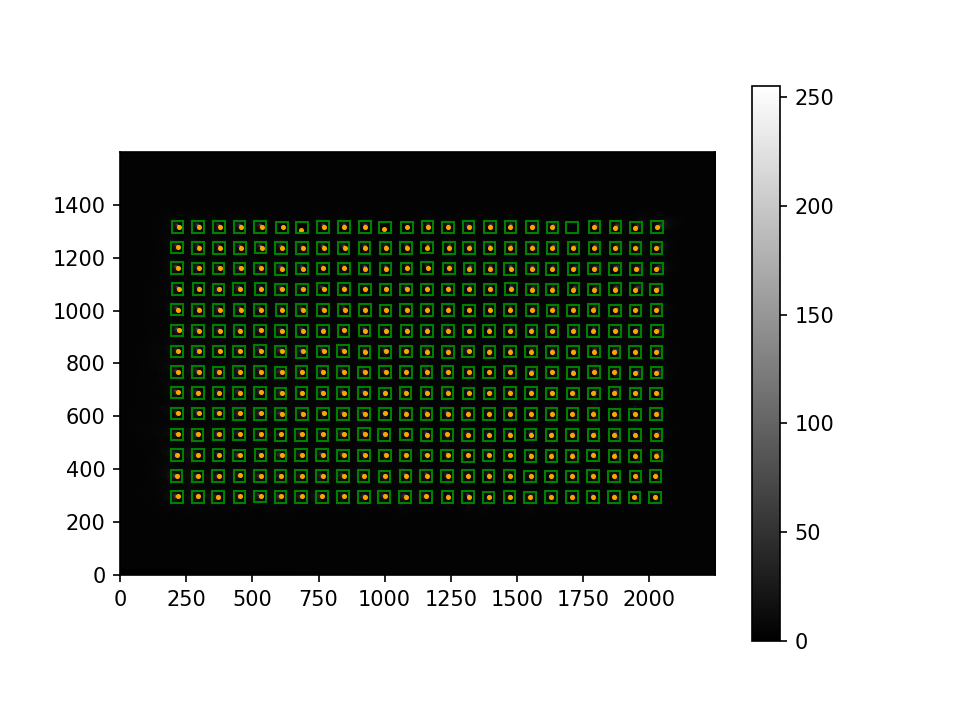

100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:03<00:00, 95.27it/s]

Fit did not converge for pixel 13x19: x= 1314.41, y= 1633.59


In [9]:
filename = filenames[4]
img_arr = load_image(filename)
idx_x_min, idx_x_max, idx_y_min, idx_y_max = [0, 1600, 50, 2300]
img_arr = crop_rotate_image(img_arr, angle = 1, crop = [idx_x_min, idx_x_max, idx_y_min, idx_y_max])

z_pos = float(filename.split("_")[1].replace("mm", ""))
beam_data_dict = extract_beam_data(img_arr, z_pos, box_width = 60, plot = True)
beam_ids = list(beam_data_dict.keys())


## Collect information from in-and-out pictures, for all the beams --> Store data into list_beam_data

################## 4


<IPython.core.display.Javascript object>


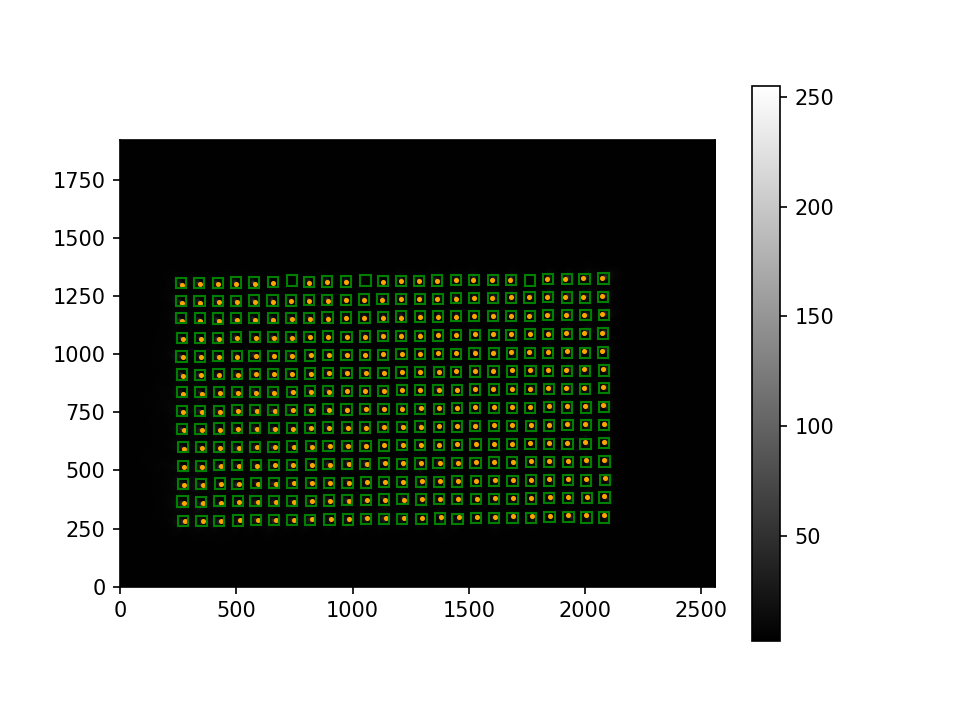

 96%|████████████████████████████████████████████████████████████████████████████▏  | 324/336 [00:03<00:00, 101.05it/s]

Fit did not converge for pixel 13x6: x= 1304.43, y= 658.12
Fit did not converge for pixel 13x10: x= 1310.43, y= 970.94
Fit did not converge for pixel 13x19: x= 1320.83, y= 1677.45


100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:03<00:00, 94.35it/s]

################## 5


<IPython.core.display.Javascript object>


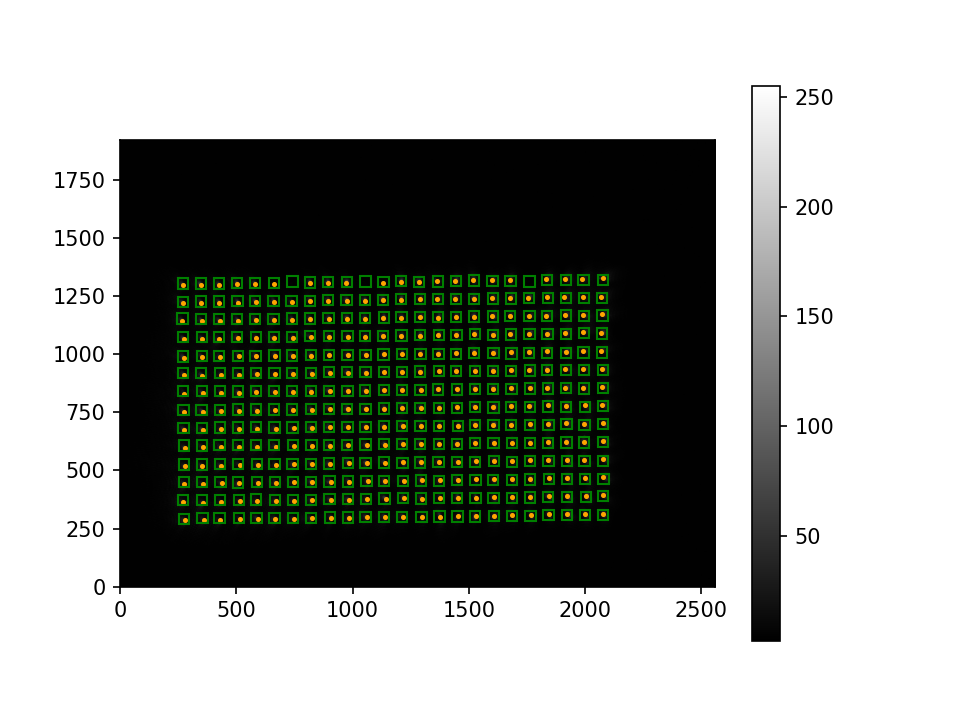

 96%|█████████████████████████████████████████████████████████████████████████████▏  | 324/336 [00:03<00:00, 71.62it/s]

Fit did not converge for pixel 13x6: x= 1300.84, y= 662.45
Fit did not converge for pixel 13x10: x= 1307.95, y= 973.42


100%|████████████████████████████████████████████████████████████████████████████████| 336/336 [00:03<00:00, 88.55it/s]

Fit did not converge for pixel 13x19: x= 1319.01, y= 1676.04
################## 6


<IPython.core.display.Javascript object>


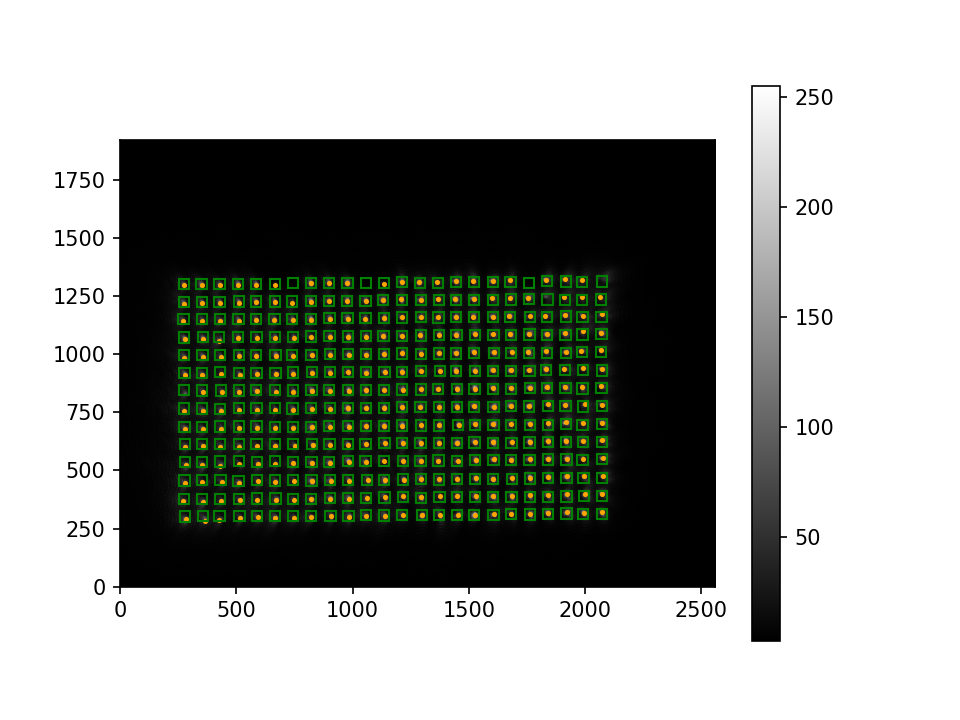

 55%|███████████████████████████████████████████▎                                   | 184/336 [00:01<00:01, 143.67it/s]

Fit did not converge for pixel 7x0: x= 783.38, y= 2073.37


 94%|██████████████████████████████████████████████████████████████████████████     | 315/336 [00:02<00:00, 137.32it/s]

Fit did not converge for pixel 12x20: x= 1242.32, y= 1755.39
Fit did not converge for pixel 13x6: x= 1297.03, y= 665.85


100%|███████████████████████████████████████████████████████████████████████████████| 336/336 [00:02<00:00, 129.01it/s]

Fit did not converge for pixel 13x10: x= 1306.52, y= 977.15
Fit did not converge for pixel 13x19: x= 1317.41, y= 1677.58
Fit did not converge for pixel 13x23: x= 1320.01, y= 1984.68


In [11]:
list_beam_data_dict = []
for idx in [4,5,6]:
    print("##################", idx)
    filename = filenames[idx]
    z_pos = float(filename.split("_")[1].replace("mm", ""))
    img_arr = load_image(filename)
    beam_data_dict_i = extract_beam_data(img_arr, z_pos, box_width = 60, plot = True)
    list_beam_data_dict.append(beam_data_dict_i)
    
#extract_beam_pos(img_arr)

### Functions to extract direction vectors

In [12]:
def extract_single_beam(list_beam_data_dict, pixel_id):
    """
    Extract the single beam (e.g. 13x3) info,
    """
    single_beam_data = []
    single_beam_coords = []
    for data_i in list_beam_data_dict:
        single_beam_data.append(data_i[pixel_id])
        x = data_i[pixel_id][1][0]
        y = data_i[pixel_id][1][1]
        z = data_i[pixel_id][0]
        single_beam_coords.append(np.array([x,y,z]))
        
    return single_beam_data, np.array(single_beam_coords)


#possibly obsolete
def extract_single_beam_coords(single_beam_data, pixel_id):
    single_beam_data = []
    for data_i in list_beam_data_dict:
        single_beam_data.append(data_i[pixel_id])
           
    return single_beam_data
    
    single_beam_coords = []
    for data_i in list_beam_data_dict:
        #data_i = [z_pos, pos_arr, pos_sub_arr, beam_sub_arr[i]]
        coords_i = [data_i[0][0], data_i[0][1], data_i[0]] #z, x, y
        single_beam_coords.append(coords_i)
        
    return single_beam_coords

#possibly obsolete
def to_um(single_beam_coords, magnification):
    """Converts from pixel units to microns. The constant of proportionality is calculated"""
    single_beam_coords[:, 0] = single_beam_coords[:, 0]*magnification
    single_beam_coords[:, 1] = single_beam_coords[:, 1]*magnification
    single_beam_coords[:, 2] = single_beam_coords[:, 2]*1000
    return single_beam_coords

def extract_all_beams_coords(list_beam_data_dict, beam_ids):
    """
    Returns a pandas Dataframe with the coordinates of all the beams in pixel units, for all the
    z values.
    """    
    
    beam_coords_store = [] #stores the coords of the beams, for all z

    for i, beam_id in enumerate(beam_ids):
        try:
            single_beam_data, single_beam_coords = extract_single_beam(list_beam_data_dict, beam_id)
            for z_snapshot in single_beam_data:
                z = z_snapshot[0]
                x, y = z_snapshot[1]
                data_row_i = [beam_id, x, y, z]
                beam_coords_store.append(data_row_i)
        
        except KeyError:
            print(f"Key error with {beam_id}")
        
    beam_coords_store = pd.DataFrame(data = beam_coords_store, columns = ["beam_id", "x_px", "y_px", "z_px"]).\
                        set_index("beam_id")
    
    return beam_coords_store


def get_dir_vector(single_beam_coords, plot = True):
    """
    Given a set of points in 3D, find the direction vector of the line that passes closest to them.
    The director vector is in cartesian coordinates
    """

    coords = single_beam_coords
    pca = PCA(n_components=1)
    pca.fit(coords)
    dir_vector = pca.components_[0]
    
    if dir_vector[2]<0: #if z is negative, invert direction
        dir_vector = -1 * dir_vector 

    if plot:
        # Create plot
        origin = np.mean(coords, axis=0)
        euclidian_distance = np.linalg.norm(coords - origin, axis=1)
        extent = np.max(euclidian_distance)

        line = np.vstack((origin - dir_vector * extent,
                          origin + dir_vector * extent))

        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(coords[:, 0], coords[:, 1], coords[:,2])
        ax.plot(line[:, 0], line[:, 1], line[:, 2], 'r')
        
    return np.array(dir_vector)


### Transfer information from list of dictionaries to dataframe - beam_coords_store

In [14]:
single_beam_data, single_beam_coords = extract_single_beam(list_beam_data_dict, "0x0")
beams_df = extract_all_beams_coords(list_beam_data_dict, beam_ids)

#Convert coordinates to um
beams_df["x_um"] = beams_df["x_px"] * magnification
beams_df["y_um"] = beams_df["y_px"] * magnification
beams_df["z_um"] = beams_df["z_px"] * 1000

#Extract direction vectors
dir_vector_store = []
for index in beams_df.index:
    dir_vector_i = get_dir_vector(beams_df.loc[index, ["x_um", "y_um", "z_um"]].values, plot = False)
    dir_vector_store.append(dir_vector_i)    
dir_vector_store = np.array(dir_vector_store)

beams_df["x_dir"] = dir_vector_store[:, 0]
beams_df["y_dir"] = dir_vector_store[:, 1]
beams_df["z_dir"] = dir_vector_store[:, 2]

#Direction vectors in spherical coordinates
beams_df["theta"] = np.arccos(beams_df.z_dir / 
                            np.sqrt(beams_df.x_dir**2
                                    +beams_df.y_dir**2
                                    +beams_df.z_dir**2))

beams_df["phi"] = beams_df.apply(lambda row: math.atan2(row.y_dir, row.x_dir), axis = 1)

beams_df["theta_deg"] = np.degrees(beams_df["theta"])
beams_df["phi_deg"] = np.degrees(beams_df["phi"])


beams_df

Key error with 7x0
Key error with 12x20
Key error with 13x6
Key error with 13x10
Key error with 13x23


,x_px,y_px,z_px,x_um,y_um,z_um,x_dir,y_dir,z_dir,theta,phi,theta_deg,phi_deg
beam_id,,,,,,,,,,,,,
0x0,280.467739,278.215439,10.0,797.443206,791.039327,10000.0,0.014324,0.004404,0.999888,0.014986,0.298274,0.858647,17.089836
0x0,284.869014,279.978828,11.0,809.957181,796.053103,11000.0,0.014324,0.004404,0.999888,0.014986,0.298274,0.858647,17.089836
0x0,290.544588,281.313532,12.0,826.094325,799.848017,12000.0,0.014324,0.004404,0.999888,0.014986,0.298274,0.858647,17.089836
0x1,281.954786,358.552950,10.0,801.671269,1019.459902,10000.0,0.003729,0.011561,0.999926,0.012147,1.258807,0.695996,72.124315
0x1,286.336163,361.129149,11.0,814.128671,1026.784710,11000.0,0.003729,0.011561,0.999926,0.012147,1.258807,0.695996,72.124315
...,...,...,...,...,...,...,...,...,...,...,...,...,...
13x21,1322.594968,1911.831383,11.0,3760.483733,5435.837118,11000.0,-0.004690,-0.002197,0.999987,0.005179,-2.703529,0.296742,-154.900822
13x21,1321.816109,1913.467953,12.0,3758.269235,5440.490316,12000.0,-0.004690,-0.002197,0.999987,0.005179,-2.703529,0.296742,-154.900822
13x22,1326.330752,1991.782990,10.0,3771.105546,5663.160466,10000.0,-0.008990,-0.010092,0.999909,0.013516,-2.298515,0.774425,-131.695204


## Reduce to angular information 

In [80]:
beams_dir_df = beam_coords_store.reset_index().groupby(by = "beam_id")[["theta_deg", "phi_deg"]].mean()
beams_dir_df = beams_dir_df.sort_index()
beams_dir_df = beams_dir_df.reset_index()

pixel_ids = beams_dir_df["beam_id"].str.split("x", n=2, expand = True)
beams_dir_df["pixel_x"] = pixel_ids[0].astype(float)
beams_dir_df["pixel_y"] = pixel_ids[1].astype(float)
beam_dir_df = beam_dir_df.set_index("beam_id")
beam_dir_df

,theta_deg,phi_deg,pixel_x,pixel_y
beam_id,,,,
0x0,0.858647,17.089836,0,0
0x1,0.695996,72.124315,0,1
0x10,1.104022,-29.896202,0,10
0x11,0.884487,-19.110196,0,11
0x12,1.054756,-20.202591,0,12
...,...,...,...,...
9x5,0.670154,73.623379,9,5
9x6,0.235878,99.904801,9,6
9x7,0.535959,82.647281,9,7


<IPython.core.display.Javascript object>


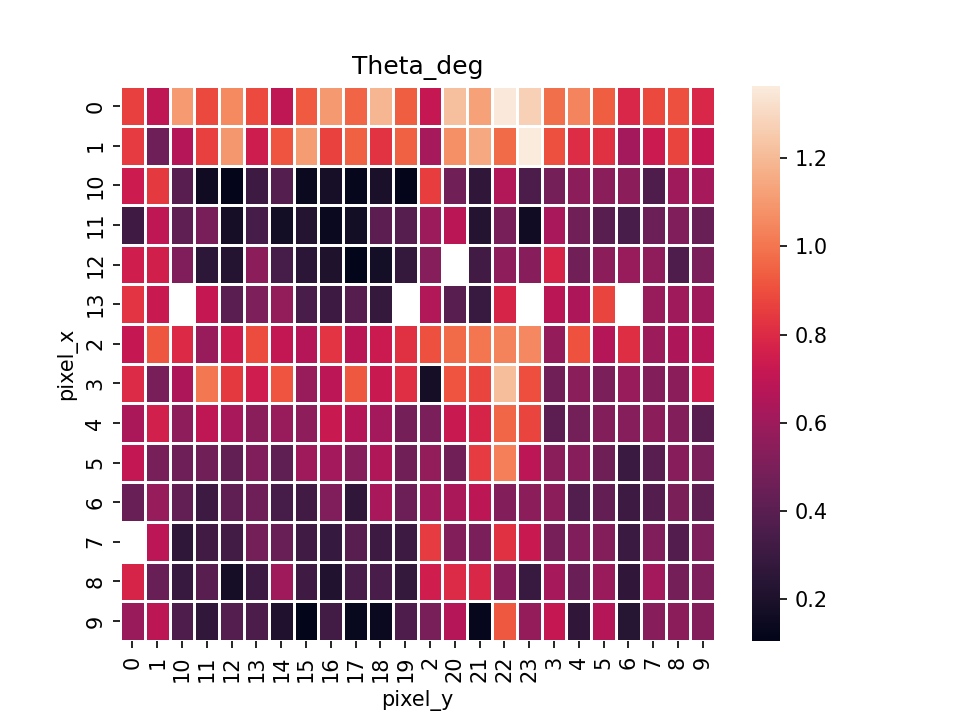

<IPython.core.display.Javascript object>


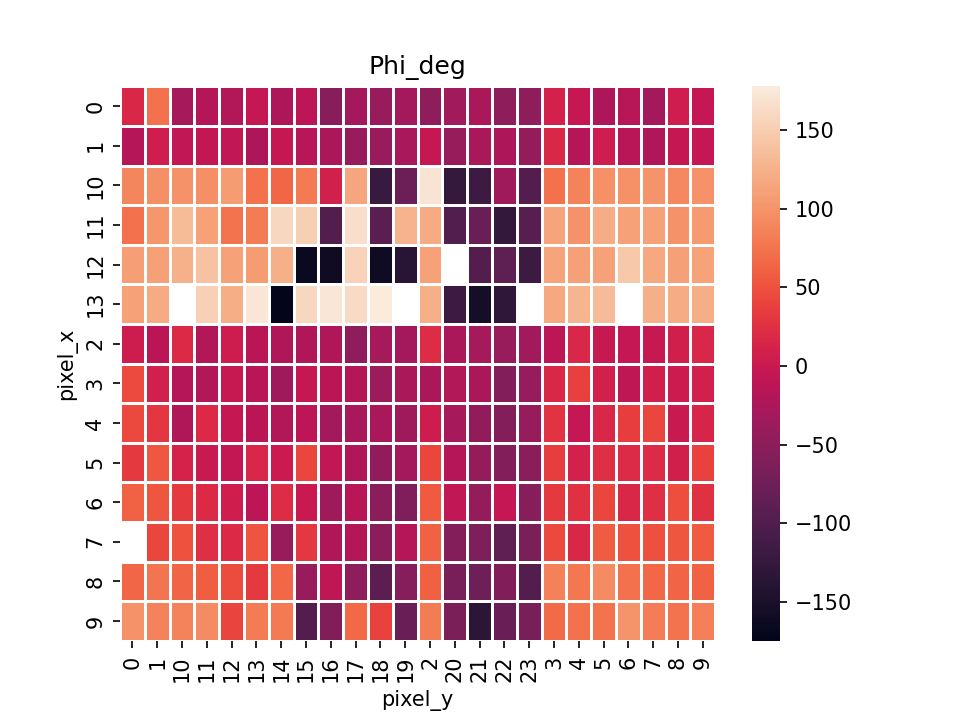

Text(0.5, 1.0, 'Phi_deg')

In [48]:
table_theta_deg = pd.pivot_table(beam_dir_df, values='theta_deg', index=["pixel_x"],
                   columns=['pixel_y'], aggfunc=np.sum)
f, ax = plt.subplots()
sns.heatmap(table_theta_deg, annot=False, linewidths=.5, ax = ax)
plt.show()
ax.set_title("Theta_deg")


table_phi_deg = pd.pivot_table(beam_dir_df, values='phi_deg', index=["pixel_x"],
                   columns=['pixel_y'], aggfunc=np.sum)
f, ax = plt.subplots()
sns.heatmap(table_phi_deg, annot=False, linewidths=.5, ax = ax)
plt.show()
ax.set_title("Phi_deg")

## Represent in polar plots

In [100]:
beam_dir_df.loc[label]["theta_deg"]

0.9032434670227163

<IPython.core.display.Javascript object>


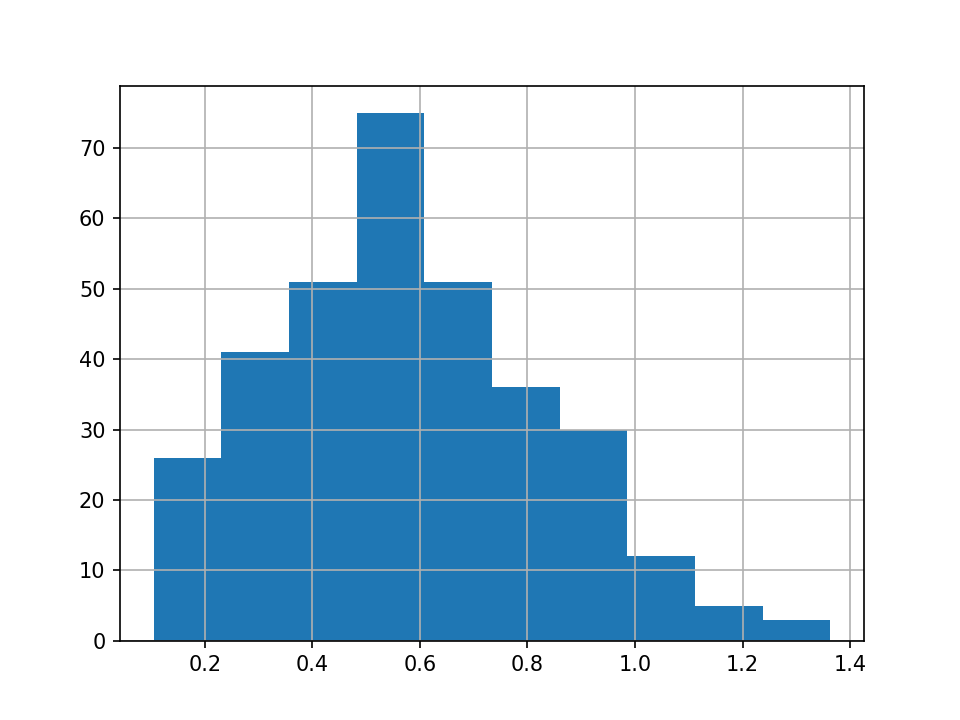

<AxesSubplot:>

In [159]:
f, ax = plt.subplots()
beam_dir_df.theta_deg.hist(ax = ax)

In [171]:
n_rows

13

In [170]:
ax_arr.shape

(13, 23)

<IPython.core.display.Javascript object>


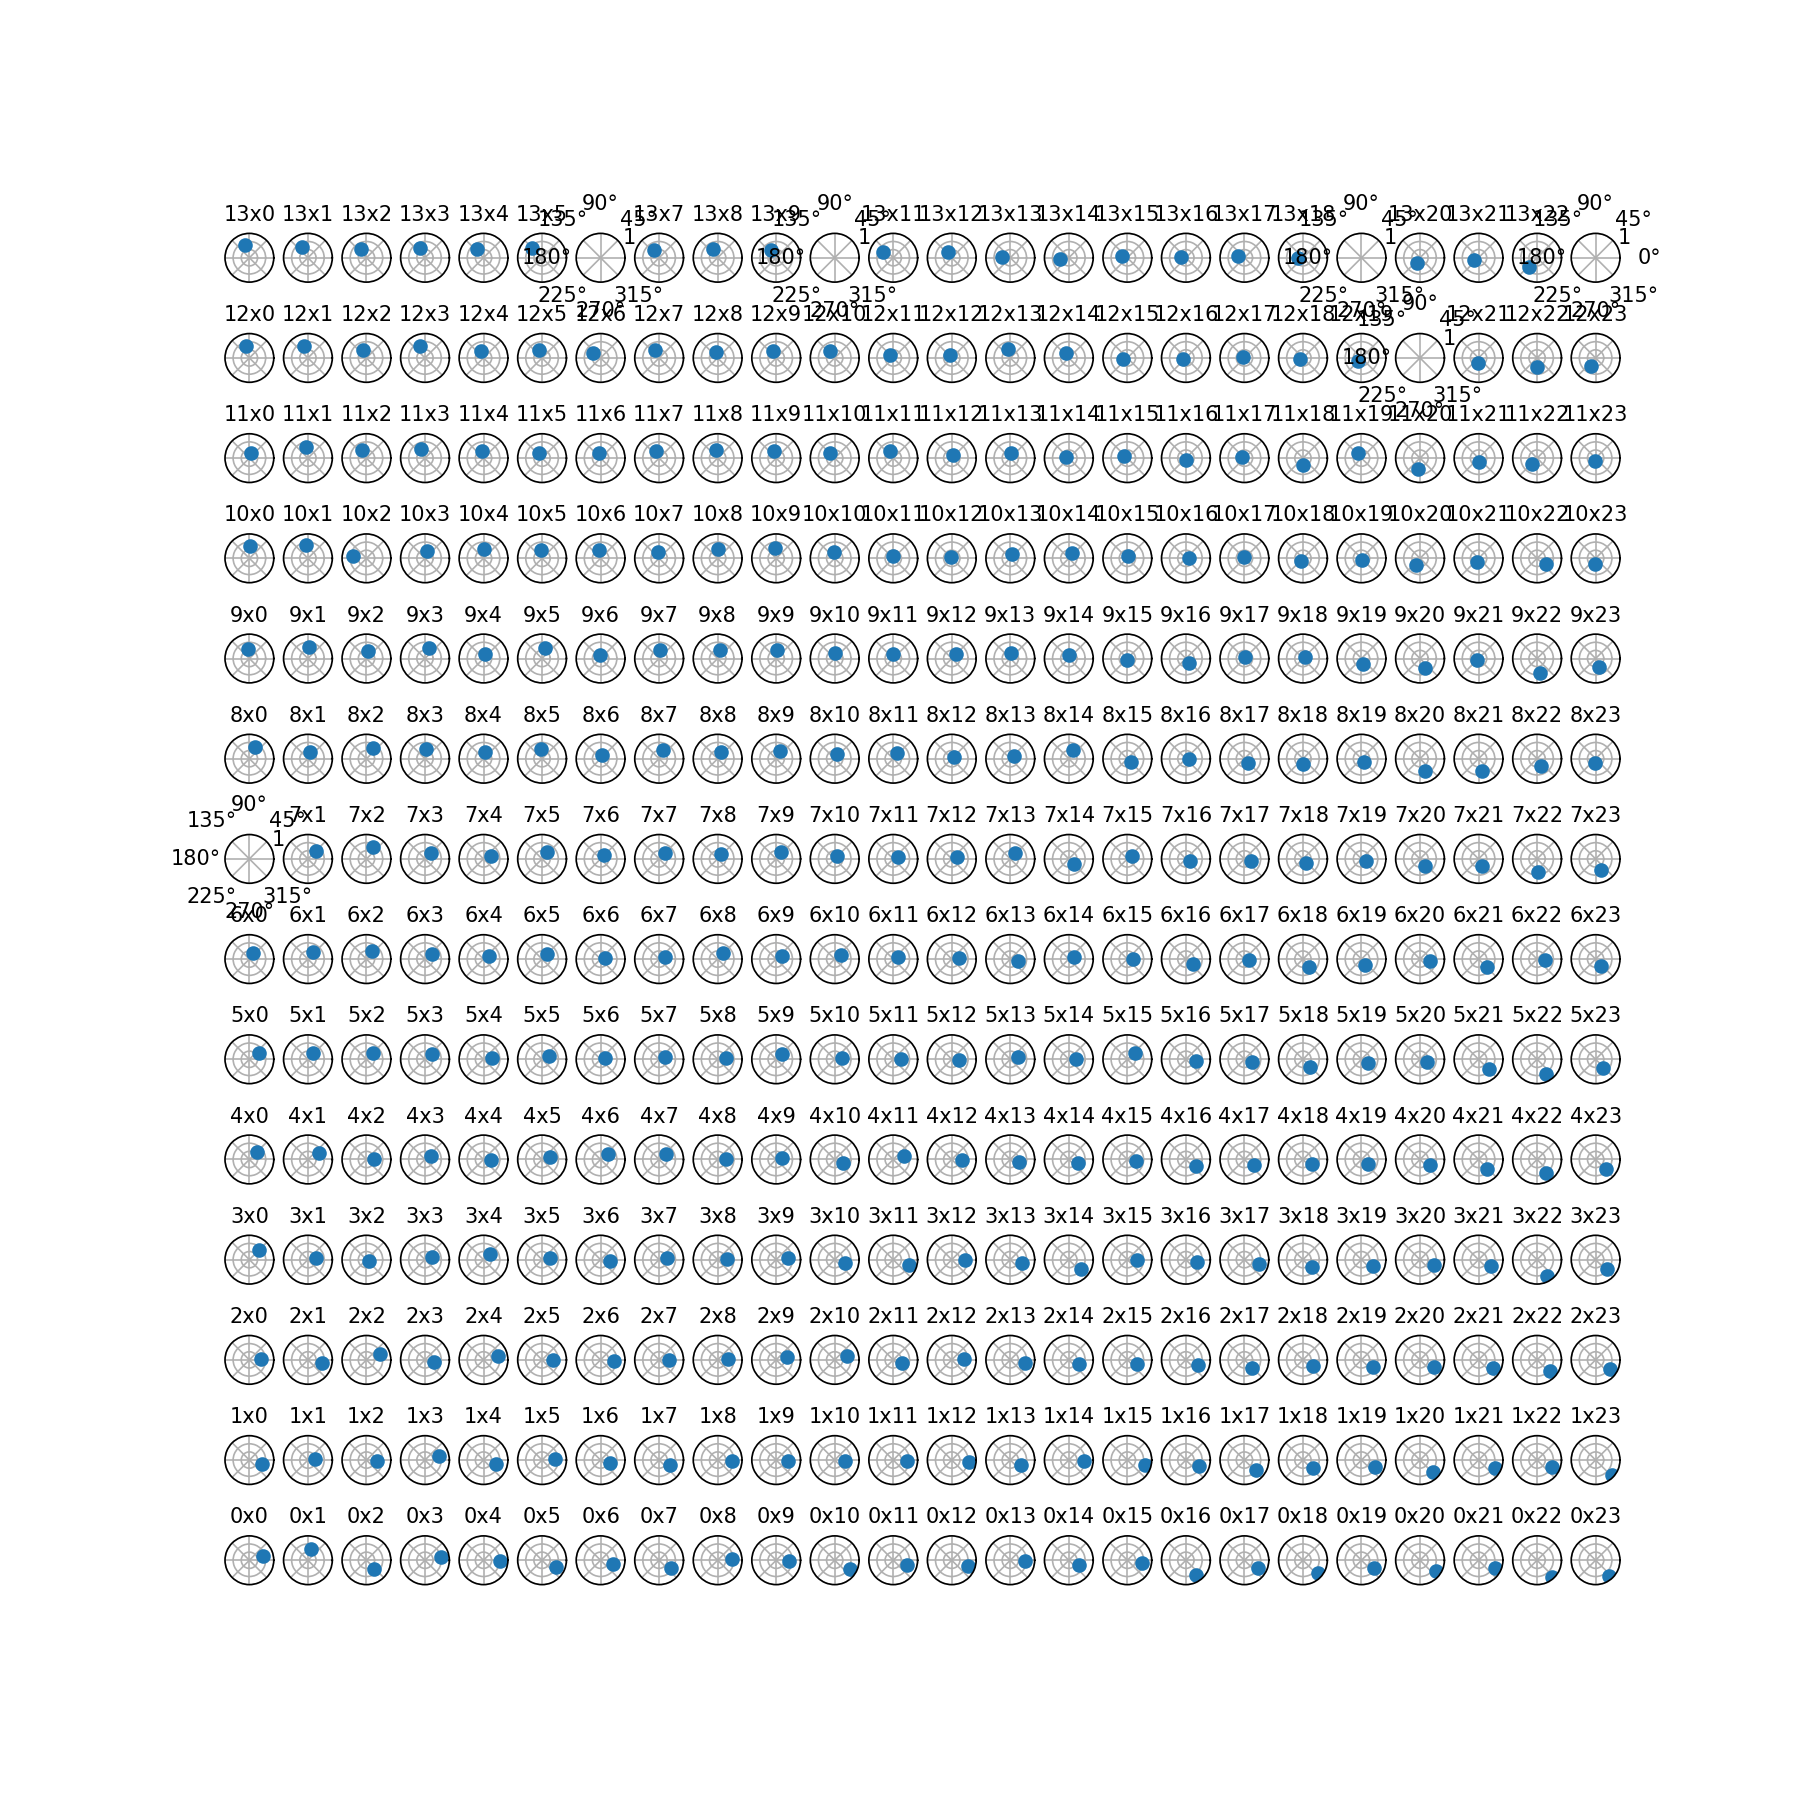

C:\Users\Rui\AppData\Local\Temp/ipykernel_44244/1383871884.py:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['', '', '', '', '', '', '', ''])


In [191]:
n_rows = int(beams_dir_df.pixel_x.max())+1
n_cols = int(beams_dir_df.pixel_y.max())+1

#n_rows = 3
#n_cols = 3

x_pixel_arr = np.sort(beam_dir_df.pixel_x.unique().astype(float))
y_pixel_arr = np.sort(beam_dir_df.pixel_y.unique().astype(float))

#for testing
#x_pixel_arr = [0,1,2,]
#y_pixel_arr = [0,1,2,]

fig, ax_arr = plt.subplots(subplot_kw={'projection': 'polar'},
                           figsize = (12, 12),
                           nrows = n_rows,
                           ncols = n_cols)

for i, x_pixel_id in enumerate(x_pixel_arr):
    for j, y_pixel_id in enumerate(y_pixel_arr):
        ax = ax_arr[-i-1][j]
        
        label = f"{x_pixel_id:.0f}x{y_pixel_id:.0f}"
        try:
            theta = np.radians(beam_dir_df.loc[label]["theta_deg"])
            phi = np.radians(beam_dir_df.loc[label]["phi_deg"])
            #print("phi_deg=", np.degrees(phi))
            #print("theta_deg=", np.degrees(theta))

          
            ax.set_rlim(0, 1.5)
            ax.set_rticks([0.5, 1, 1.5])
            ax.set_yticklabels([])

            #ax.set_rticks([])
            #ax2.set_rgrids([0.5, 1, 1.5])
                        #ax.set_xticklabels(['N', '', 'W', '', 'S', '', 'E', ''])
            ax.set_xticklabels(['', '', '', '', '', '', '', ''])
            ax.set_rlabel_position(120)

            ax.plot(phi, np.degrees(theta), "o")
            ax.set_title(f"{label}", fontsize = 10)
            
        except:
            continue

#plt.tight_layout()
plt.savefig("Chip angular emission tests.png", dpi = 300)

#ax.set_rmax(0.5)
#ax.set_rticks([0.5, 1, 1.5, 2])  # Less radial ticks
#ax.set_rlabel_position(-22.5)  # Move radial labels away from plotted line
#ax.grid(True)

In [112]:
theta

0.015764572446675222

### Repreent in polar plots

<IPython.core.display.Javascript object>


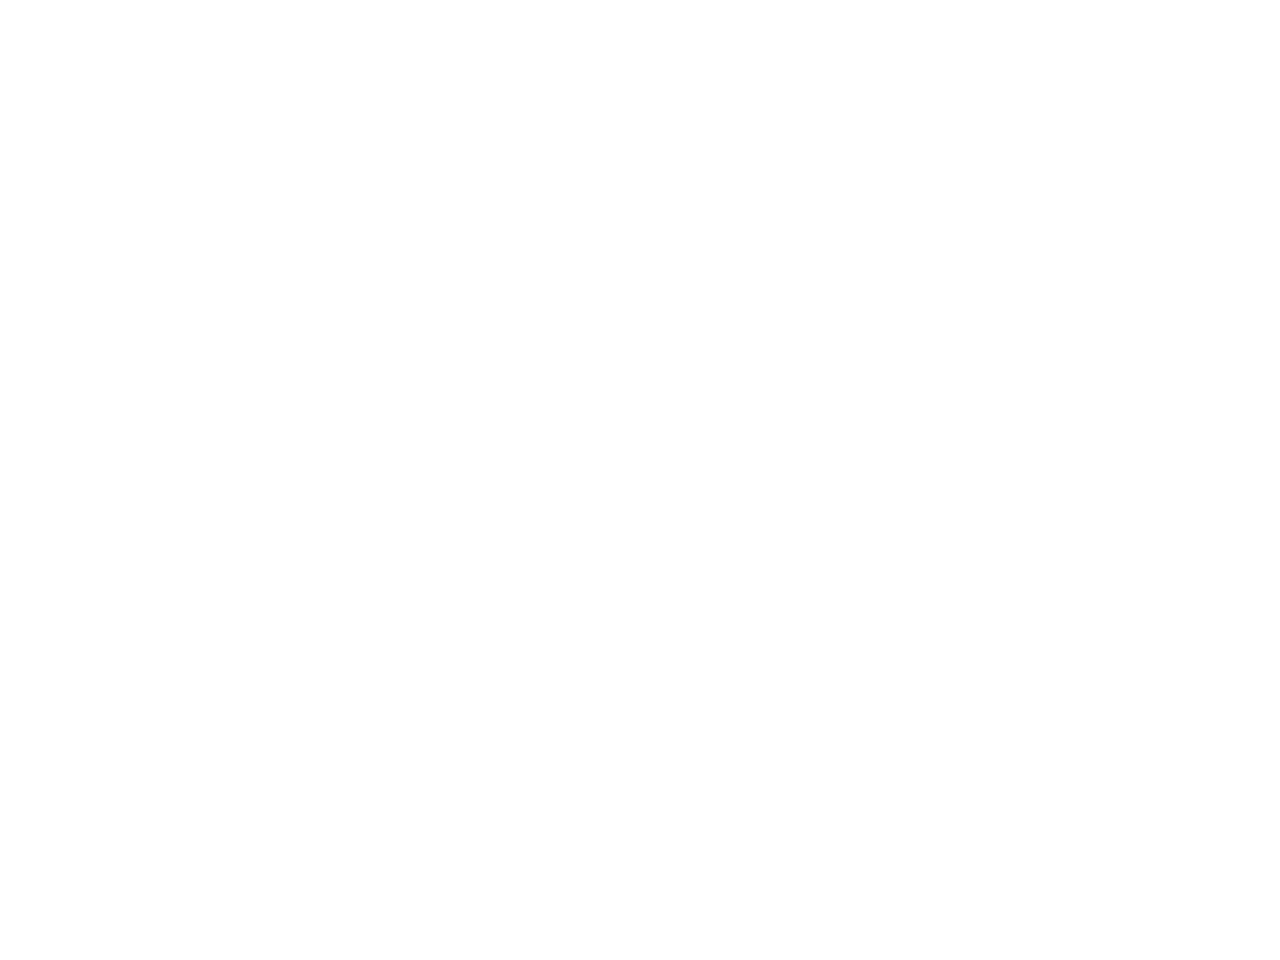

<IPython.core.display.Javascript object>


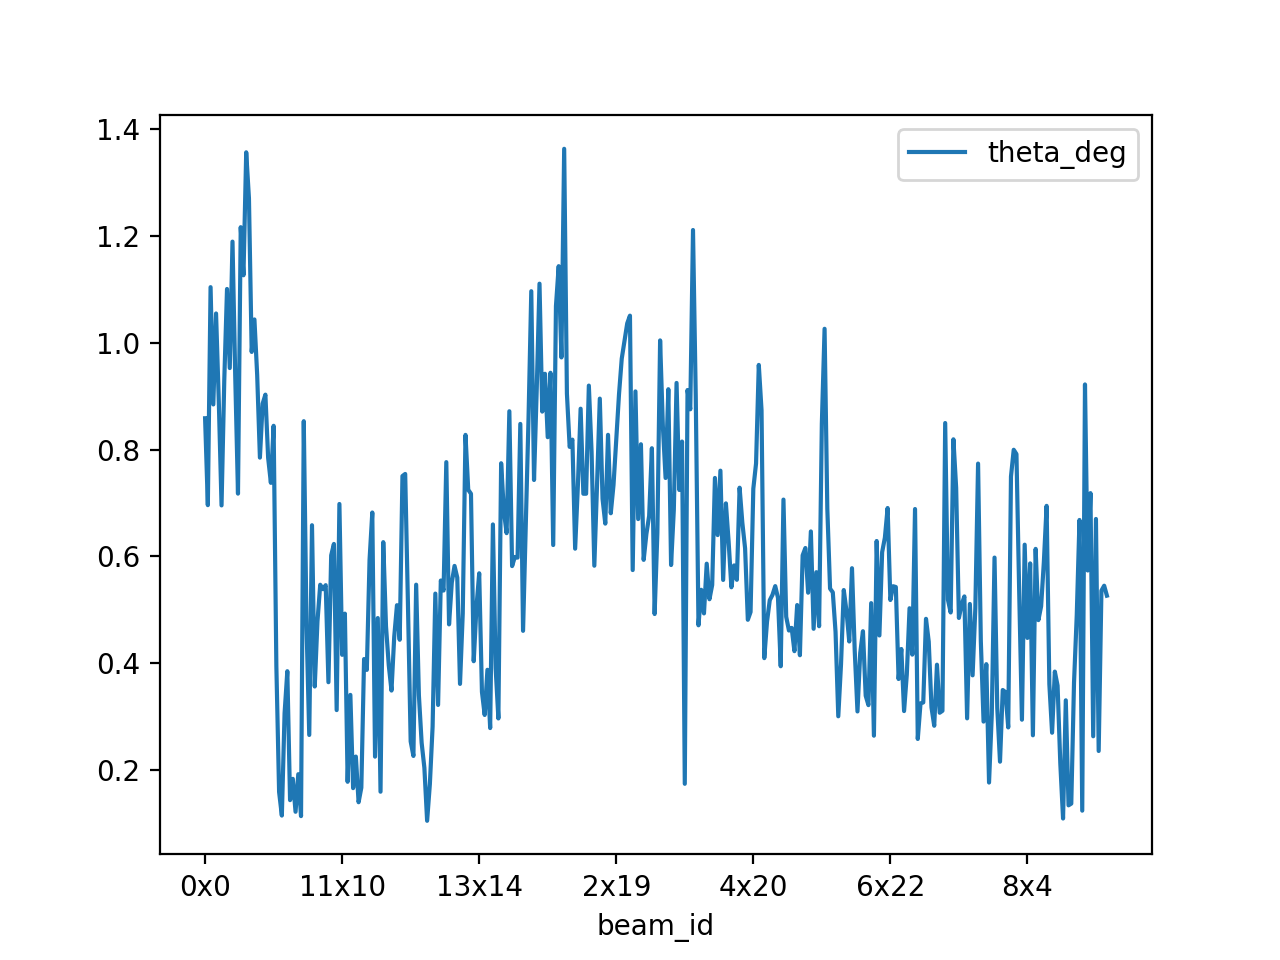

In [78]:
plt.figure()
beam_dir_store.plot(use_index = True, y = "theta_deg")
plt.show()

In [59]:
beam_coords_store

,x_px,y_px,z_px,x_um,y_um,z_um,x_dir,y_dir,z_dir,theta,phi
beam_id,,,,,,,,,,,
0x0,280.467739,278.215439,10.0,797.443206,791.039327,10000.0,0.014324,0.004404,0.999888,0.014986,0.298274
0x0,284.869014,279.978828,11.0,809.957181,796.053103,11000.0,0.014324,0.004404,0.999888,0.014986,0.298274
0x0,290.544588,281.313532,12.0,826.094325,799.848017,12000.0,0.014324,0.004404,0.999888,0.014986,0.298274
0x1,281.954786,358.552950,10.0,801.671269,1019.459902,10000.0,0.003729,0.011561,0.999926,0.012147,1.258807
0x1,286.336163,361.129149,11.0,814.128671,1026.784710,11000.0,0.003729,0.011561,0.999926,0.012147,1.258807
...,...,...,...,...,...,...,...,...,...,...,...
13x21,1322.594968,1911.831383,11.0,3760.483733,5435.837118,11000.0,-0.004690,-0.002197,0.999987,0.005179,-2.703529
13x21,1321.816109,1913.467953,12.0,3758.269235,5440.490316,12000.0,-0.004690,-0.002197,0.999987,0.005179,-2.703529
13x22,1326.330752,1991.782990,10.0,3771.105546,5663.160466,10000.0,-0.008990,-0.010092,0.999909,0.013516,-2.298515


## Archive

In [ ]:
beam_coords_store = beam_coords_store.sort_values(by = ["beam_id", "z"])
beam_coords_store

In [ ]:
beam_id = "0x2"
single_beam_data, single_beam_coords = extract_single_beam(list_beam_data_dict, beam_id)

for snapshot in single_beam_data:
    z = snapshot[0]
    x, y = snapshot[1]
    data_row = [beam_id, x, y, z]

In [ ]:
single_beam_data, single_beam_coords = extract_single_beam(list_beam_data_dict, "0x0")
single_beam_coords_um = to_um(single_beam_coords, magnification)
single_beam_coords

In [ ]:
beam_data = pick_beam(list_beam_data_dict, "0x0")
coords_arr = extract_coords(beam_data)

In [ ]:
coords_arr

In [ ]:
coords_arr

In [ ]:
pick_beam(dict_list, "1x1")

In [ ]:
box_pos_arr = beam_pos_dict["1x1"]
sub_img_arr = img_arr[int(box_pos_arr[1]-box_width/2): int(box_pos_arr[1]+box_width/2),
                     int(box_pos_arr[0]-box_width/2): int(box_pos_arr[0]+box_width/2)]
COM = ndimage.center_of_mass(sub_img_arr)

beam_pos_dict["1x1"] = COM



#Recalculate centroid
plt.figure()
plt.imshow(sub_img_arr, origin = "lower", cmap = "gray")
plt.scatter(COM[0], COM[1])


In [ ]:
test_arr = np.array([[1,2,3], [4,5,6]])
test_arr.sum(axis=0)

In [ ]:
beam_pos_dicyt

In [ ]:
def centroid(arr_1D):
    # Calculate the centroid
    rows, cols = arr.shape
    row_indices, col_indices = np.indices((rows, cols))
    total_mass = np.sum(arr)
    centroid_row = np.sum(row_indices * arr) / total_mass
    return [centroid_row, centroid_col]

In [ ]:
sub_img_arr = img_arr[int(box_i_x-box_width/2): int(box_i_x+box_width/2), 
                        int(box_i_y-box_width/2): int(box_i_y+box_width/2)]

plot_image(sub_img_arr)
centroid_pos = centroid(sub_img_arr)
plt.scatter(x = centroid_pos[0], y = centroid_pos[1])

In [ ]:
plt.figure()
plt.plot(sub_img_arr.sum(axis=0))

In [ ]:
filename = filenames[4]
img_arr = load_image(filename)
ax = plot_image(img_arr)

box_i_x= 280
box_i_y = 280
box_width = 50

# Create a Rectangle patch
rect = patches.Rectangle((box_i_x-box_width/2, box_i_x-box_width/2), box_width, box_width, linewidth=1, edgecolor='r', facecolor='none')
ax.add_patch(rect)
ax.set_title(f"{filename}")

In [ ]:
def detect_peaks(image):
    """
    Takes an image and detect the peaks usingthe local maximum filter.
    Returns a boolean mask of the peaks (i.e. 1 when
    the pixel's value is the neighborhood maximum, 0 otherwise)
    """

    # define an 8-connected neighborhood
    neighborhood = generate_binary_structure(2,2)

    #apply the local maximum filter; all pixel of maximal value 
    #in their neighborhood are set to 1
    local_max = maximum_filter(image, footprint=neighborhood)==image
    #local_max is a mask that contains the peaks we are 
    #looking for, but also the background.
    #In order to isolate the peaks we must remove the background from the mask.

    #we create the mask of the background
    background = (image==0)

    #a little technicality: we must erode the background in order to 
    #successfully subtract it form local_max, otherwise a line will 
    #appear along the background border (artifact of the local maximum filter)
    eroded_background = binary_erosion(background, structure=neighborhood, border_value=1)

    #we obtain the final mask, containing only peaks, 
    #by removing the background from the local_max mask (xor operation)
    detected_peaks = local_max ^ eroded_background

    return detected_peaks


In [ ]:
# Initialize
fp = findpeaks(method='mask')
# Example 2d image
X = fp.import_example('2dpeaks')
# Fit topology method on the 1d-vector
results = fp.fit(X)
# The output contains multiple variables
print(results.keys())
# dict_keys(['Xraw', 'Xproc', 'Xdetect'])

In [ ]:
img_arr.shape

In [ ]:
img_arr = load_image(filenames[4])
plot_image(img_arr)


fp = findpeaks(method='mask')
fp.fit(img_arr)

# Plot the pre-processing steps
fp.plot_preprocessing()
# Plot all
fp.plot()

# Initialize
fp = findpeaks(method='topology')
# Fit
fp.fit(img_arr)

fp.plot()

detected_peaks = detect_peaks(img_arr)
plt.imshow(detected_peaks)